In [2]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt

In [12]:
sales = pd.read_csv("data/dataset1.csv")
logs1 = pd.read_csv("data/dataset2a for q1 q2.csv")
logs2 = pd.read_csv("data/dataset2b for q3 q4.csv")
tickets = pd.read_csv("data/dataset3.csv")
logs = pd.concat([logs1, logs2], axis = 0)

In [20]:
sales.head()

,customer_id,company_name,country,region,is_eu,industry,company_size_bucket,annual_contract_value,product_tier,sales_segment,acquisition_channel,contract_start_date,contract_end_date,renewed_flag,discount_pct,initial_onboarding_score,is_churned
0,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,Partner,5/2/2023,NaN,1,0.03,7.0,0
1,C100001,Company_1,UK,Europe,1,Wholesale,10-Jan,1799.72,Starter,SMB_Field,Inbound,2/18/2023,NaN,1,0.15,4.9,0
2,C100002,Company_2,US,North America,0,Manufacturing,10-Jan,1770.83,Starter,SMB_Field,Inbound,11/12/2023,5/13/2024,0,0.37,4.8,1
3,C100003,Company_3,France,Europe,1,NaN,10-Jan,1790.30,Starter,SMB_Field,Outbound,8/6/2023,NaN,1,0.10,8.0,0
4,C100004,Company_4,Netherlands,Europe,1,Professional Services,10-Jan,1552.00,Starter,SMB_Inside,Inbound,9/9/2023,3/10/2024,0,0.11,3.8,1


In [21]:
logs.head()

,customer_id,date,logins,feature_events,session_minutes
0,C100000,2024-01-01,5.0,0.0,32.23
1,C100000,2024-01-02,1.0,1.0,18.08
2,C100000,2024-01-03,3.0,1.0,9.10
3,C100000,2024-01-04,3.0,1.0,37.60
4,C100000,2024-01-05,5.0,2.0,25.20


In [22]:
tickets.head()

,ticket_id,customer_id,created_at,channel,priority,issue_category,ticket_text,sentiment,first_response_hours,resolution_hours,resolved
0,200001,C100000,2024-05-12T23:17,Chat,Medium,product_performance,Dashboard loads very slowly during peak hours.,0.44,0.11,14.88,1
1,200002,C100001,2024-06-28T18:27,Email,Low,product_performance,Dashboard loads very slowly during peak hours.,-0.50,8.12,9.37,1
2,200003,C100002,2024-11-25T16:38,Email,Medium,product_usability,The new dashboard is confusing for my staff.,-0.50,2.97,31.65,1
3,200004,C100003,2024-11-02T14:37,Phone,High,billing_admin,I need to change our billing email and can't f...,-0.11,0.10,12.49,1
4,200005,C100004,2024-10-17T22:27,Phone,Medium,product_performance,Inventory sync takes too long to complete.,0.20,5.19,35.67,1


In [11]:
print(f"Sales Data Size: {len(sales)}")
print(f"Logs Data Size: {len(logs)}")
print(f"Tickets Data Size: {len(tickets)}")

Sales Data Size: 3000
Logs Data Size: 1098000
Tickets Data Size: 6429


### Sales EDA
* Questions
    * **DEFINITION OF CHURN** contract_end_date missingness doesn't match is_churned, so what does it mean if there's a contract_end_date but is not considered churned?
* Preprocessing Notes
    * TODO: 30% of industry is missing, we need to decide if this missingness is a signal
    * Sales table doesn't have timestamp, need to use contract start & end date to declare the "Customer Churn has spiked from 4% to 12% in a single quarter"

#### Missing Values

In [24]:
sales.dtypes

customer_id                  object
company_name                 object
country                      object
region                       object
is_eu                         int64
industry                     object
company_size_bucket          object
annual_contract_value       float64
product_tier                 object
sales_segment                object
acquisition_channel          object
contract_start_date          object
contract_end_date            object
renewed_flag                  int64
discount_pct                float64
initial_onboarding_score    float64
is_churned                    int64
dtype: object

In [75]:
sales["industry"] = sales["industry"].fillna("Missing")

In [31]:
# convert contract_start_date and end_date to DateTime object
sales["contract_start_date"] = pd.to_datetime(sales["contract_start_date"])
sales["contract_end_date"] = pd.to_datetime(sales["contract_end_date"])

In [18]:
# missingness report
missing_counts = sales.isna().sum()
missing_perc = missing_counts/len(sales)
print(missing_perc)

customer_id                 0.000000
company_name                0.000000
country                     0.000000
region                      0.000000
is_eu                       0.000000
industry                    0.287333
company_size_bucket         0.000000
annual_contract_value       0.000000
product_tier                0.000000
sales_segment               0.000000
acquisition_channel         0.000000
contract_start_date         0.000000
contract_end_date           0.476000
renewed_flag                0.000000
discount_pct                0.000000
initial_onboarding_score    0.000000
is_churned                  0.000000
dtype: float64


In [19]:
# Does contract_end_date match is_churned
sales["is_churned"].value_counts()/len(sales)

is_churned
0    0.878667
1    0.121333
Name: count, dtype: float64

In [60]:
# Does contract_end_date match is_churned
sales["renewed_flag"].value_counts()/len(sales)

renewed_flag
0    0.524
1    0.476
Name: count, dtype: float64

In [73]:
# 1. Define the boolean condition for contractual churn:
#    (Renewed Flag is 0) AND (Contract End Date is NOT missing)
contractual_churn_condition = (sales["renewed_flag"] == 0) & (~sales["contract_end_date"].isna())

# 2. Calculate the proportion of True and False values
#    We convert the boolean Series to a pandas Series of values to use .value_counts()
proportions = pd.Series(contractual_churn_condition.values).value_counts(normalize=True)

# 3. Print the result
print("Proportions of Contractual Churn (True) vs. Not Churn (False):")
print(proportions)

Proportions of Contractual Churn (True) vs. Not Churn (False):
True     0.524
False    0.476
Name: proportion, dtype: float64


#### company_size_bucket

In [ ]:
# company size bucket: Excel most likely read 1-10 as Jan 10th and 11-50 as Nov-50. engineer
sales["company_size_bucket"].value_counts()

company_size_bucket
10-Jan      1035
Nov-50       859
51-200       632
201-1000     307
1000+        167
Name: count, dtype: int64

In [25]:
sales.loc[sales["company_size_bucket"] == "10-Jan", "company_size_bucket"] = "1-10"
sales.loc[sales["company_size_bucket"] == "Nov-50", "company_size_bucket"] = "11-50"
sales["company_size_bucket"].value_counts()

company_size_bucket
1-10        1035
11-50        859
51-200       632
201-1000     307
1000+        167
Name: count, dtype: int64

#### annual_contract_value

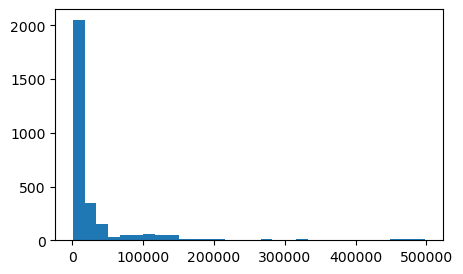

In [27]:
plt.figure(figsize=(5,3))
plt.hist(sales["annual_contract_value"], bins = 30)
plt.show()

In [28]:
print(sales["product_tier"].value_counts())
print(sales["sales_segment"].value_counts())
print(sales["acquisition_channel"].value_counts())

product_tier
Growth        1283
Starter       1124
Enterprise     593
Name: count, dtype: int64
sales_segment
SMB_Inside    1320
MidMarket      632
SMB_Field      574
Enterprise     474
Name: count, dtype: int64
acquisition_channel
Inbound      804
Outbound     765
SelfServe    721
Partner      710
Name: count, dtype: int64


#### contract dates

In [33]:
print(sales["contract_start_date"].min())
print(sales["contract_start_date"].max())

2023-01-01 00:00:00
2024-04-01 00:00:00


In [32]:
print(sales["contract_end_date"].min())
print(sales["contract_end_date"].max())

2023-04-03 00:00:00
2025-04-02 00:00:00


In [76]:
sales.to_csv("data/sales_cleaned.csv")

### Logs EDA
* Questions
    * What does feature_events mean?
    * What does it mean when logins, feature_events, and session_minutes are missing
* Preprocessing Notes
    * Maybe come up with aggregate data for each customer to be joined back to Sales data

In [35]:
logs.head()

,customer_id,date,logins,feature_events,session_minutes
0,C100000,2024-01-01,5.0,0.0,32.23
1,C100000,2024-01-02,1.0,1.0,18.08
2,C100000,2024-01-03,3.0,1.0,9.10
3,C100000,2024-01-04,3.0,1.0,37.60
4,C100000,2024-01-05,5.0,2.0,25.20


In [36]:
logs.isna().sum()/len(logs)

customer_id        0.000000
date               0.000000
logins             0.051011
feature_events     0.051011
session_minutes    0.051011
dtype: float64

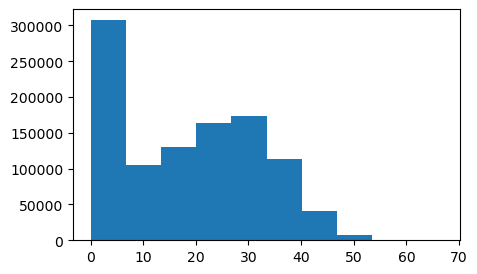

In [37]:
plt.figure(figsize=(5,3))
plt.hist(logs["session_minutes"])
plt.show()

In [61]:
logs.to_csv("data/logs.csv")

#### Tickets EDA
* Preprocessing notes:
    * Important to look at Issue_category, Sentiment, First_response_hours, Resolution_hours, Resolved distribution before and after Q3
    * Issue_category: although ticket counts increased significantly in Q3 and Q4, the distribution is roughly the same, not too much signal here
    * Sentimen: sentiment distribution also doesn't seem all that far off
    * First_response_hours: there's quite a lot and pretty extreme outliers
    * Resolution_hours: also quite a lot of outliers
    * Resolved: also similar
* Preliminary analysis shows distribution before and after Q3 are not that different. But maybe need to breakdown by Company Info (industry, size, contract size etc)

In [74]:
tickets.head(20)

,ticket_id,customer_id,created_at,channel,priority,issue_category,ticket_text,sentiment,first_response_hours,resolution_hours,resolved,Q3_Status
0,200001,C100000,2024-05-12 23:17:00,Chat,Medium,product_performance,Dashboard loads very slowly during peak hours.,0.44,0.11,14.88,1,Before Q3
1,200002,C100001,2024-06-28 18:27:00,Email,Low,product_performance,Dashboard loads very slowly during peak hours.,-0.50,8.12,9.37,1,Before Q3
2,200003,C100002,2024-11-25 16:38:00,Email,Medium,product_usability,The new dashboard is confusing for my staff.,-0.50,2.97,31.65,1,During/After Q3
3,200004,C100003,2024-11-02 14:37:00,Phone,High,billing_admin,I need to change our billing email and can't f...,-0.11,0.10,12.49,1,During/After Q3
4,200005,C100004,2024-10-17 22:27:00,Phone,Medium,product_performance,Inventory sync takes too long to complete.,0.20,5.19,35.67,1,During/After Q3
5,200006,C100005,2024-09-30 03:05:00,In-App,Low,product_usability,Bulk upload flow is not intuitive.,0.33,0.10,9.88,1,During/After Q3
6,200007,C100005,2024-06-22 01:46:00,In-App,Medium,sales_expectation,Pricing discussed in the demo does not match o...,-0.02,1.74,6.83,1,Before Q3
7,200008,C100005,2024-11-04 17:18:00,Phone,Medium,billing_admin,We were charged for extra users we don't have.,-0.33,0.22,13.77,1,During/After Q3
8,200009,C100005,2024-02-22 21:14:00,Phone,Urgent,product_performance,Dashboard loads very slowly during peak hours.,-0.12,3.09,30.52,1,Before Q3
9,200010,C100006,2024-01-23 12:17:00,In-App,Medium,product_usability,It's hard to find where to update product SKUs.,-0.26,0.10,3.40,1,Before Q3


In [39]:
tickets.isna().sum()/len(tickets)

ticket_id               0.0
customer_id             0.0
created_at              0.0
channel                 0.0
priority                0.0
issue_category          0.0
ticket_text             0.0
sentiment               0.0
first_response_hours    0.0
resolution_hours        0.0
resolved                0.0
dtype: float64

In [40]:
tickets.dtypes

ticket_id                 int64
customer_id              object
created_at               object
channel                  object
priority                 object
issue_category           object
ticket_text              object
sentiment               float64
first_response_hours    float64
resolution_hours        float64
resolved                  int64
dtype: object

In [41]:
tickets["created_at"] = pd.to_datetime(tickets["created_at"])

In [42]:
print(tickets["created_at"].min())
print(tickets["created_at"].max())

2024-01-05 15:12:00
2024-12-30 23:28:00


In [44]:
month_number = tickets['created_at'].dt.month
is_q3_or_later = month_number >= 7

tickets['Q3_Status'] = np.where(
    is_q3_or_later,
    'During/After Q3',  # Value if True (Month is 7, 8, 9, 10, 11, or 12)
    'Before Q3'         # Value if False (Month is 1, 2, 3, 4, 5, or 6)
)

In [47]:
## Ticket Counts before & after Q3
tickets_before = (tickets["Q3_Status"] == 'Before Q3').sum()
tickets_after = (tickets["Q3_Status"] == 'During/After Q3').sum()

print(f'Ticket Count Before Q3: {tickets_before}')
print(f'Ticket Count After Q3: {tickets_after}')

Ticket Count Before Q3: 1630
Ticket Count After Q3: 4799


Proportions of Issue Categories by Q3 Status:
issue_category   billing_admin  product_performance  product_usability  \
Q3_Status                                                                
Before Q3             0.279755             0.238037           0.247239   
During/After Q3       0.253178             0.250886           0.254011   

issue_category   sales_expectation  
Q3_Status                           
Before Q3                 0.234969  
During/After Q3           0.241925  


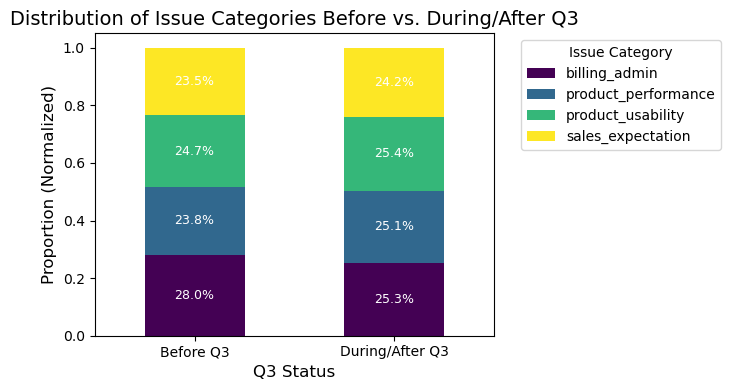

In [49]:
pivot_counts = pd.crosstab(tickets['Q3_Status'], tickets['issue_category'])

# Normalize the counts within each Q3_Status group (index) to get proportions
pivot_proportions = pivot_counts.div(pivot_counts.sum(axis=1), axis=0)

# Display the proportions table (first 5 rows)
print("Proportions of Issue Categories by Q3 Status:")
print(pivot_proportions)

# 4. Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the normalized proportions as a stacked bar chart
pivot_proportions.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

# Add labels and title
ax.set_title('Distribution of Issue Categories Before vs. During/After Q3', fontsize=14)
ax.set_xlabel('Q3 Status', fontsize=12)
ax.set_ylabel('Proportion (Normalized)', fontsize=12)
ax.tick_params(axis='x', rotation=0)

# Add legend outside the plot
ax.legend(title='Issue Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels inside the bars for clarity
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        width = bar.get_width()
        x = bar.get_x()
        y = bar.get_y()
        # Only add a label if the proportion is significant
        if height > 0.05:
             ax.text(x + width / 2, y + height / 2, f'{height:.1%}', ha='center', va='center', color='white', fontsize=9)

plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend
plt.show()

Descriptive Statistics for Sentiment Score:
         Q3_Status   min   max      mean  median       std
0        Before Q3 -1.06  0.99 -0.041374  -0.045  0.292856
1  During/After Q3 -1.23  1.03 -0.044449  -0.040  0.302501


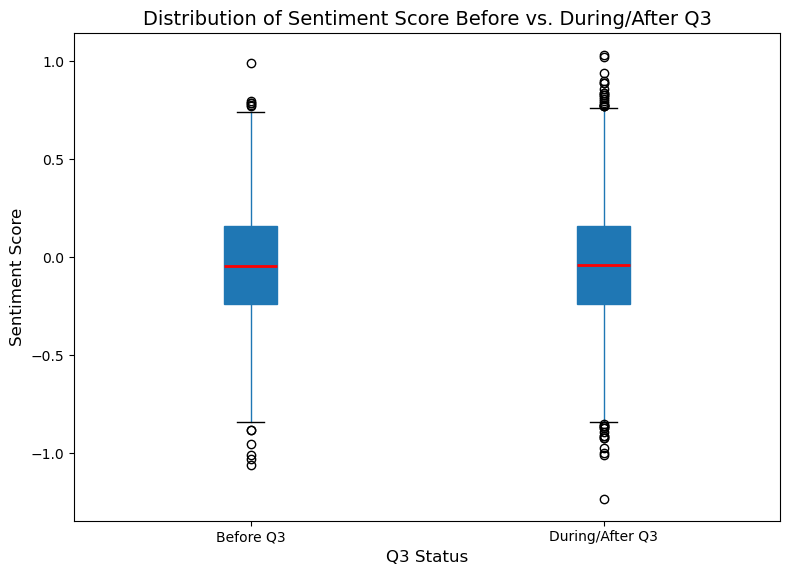

In [54]:
# 2. Generate descriptive statistics
stats = tickets.groupby('Q3_Status')['sentiment'].agg(['min','max','mean', 'median', 'std']).reset_index()
print("Descriptive Statistics for Sentiment Score:")
print(stats)

# 3. Create the box plot
fig, ax = plt.subplots(figsize=(8, 6))

tickets.boxplot(column='sentiment', by='Q3_Status', ax=ax, grid=False, patch_artist=True, medianprops={'color': 'red', 'linewidth': 2})

# Clean up the plot
plt.suptitle('') # Suppress the default title generated by df.boxplot
ax.set_title('Distribution of Sentiment Score Before vs. During/After Q3', fontsize=14)
ax.set_xlabel('Q3 Status', fontsize=12)
ax.set_ylabel('Sentiment Score', fontsize=12)
plt.xticks(rotation=0) # Ensure x-axis labels are horizontal
plt.tight_layout()
plt.show()

Descriptive Statistics for Sentiment Score:
         Q3_Status  min    max      mean  median       std
0        Before Q3  0.1  41.84  3.789534    2.46  4.166078
1  During/After Q3  0.1  41.61  3.806899    2.35  4.364305


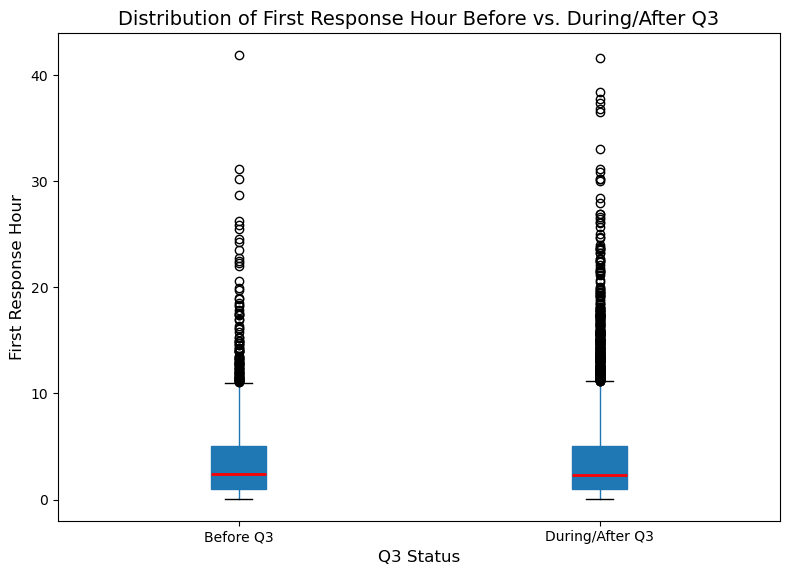

In [56]:
# 2. Generate descriptive statistics
stats = tickets.groupby('Q3_Status')['first_response_hours'].agg(['min','max','mean', 'median', 'std']).reset_index()
print("Descriptive Statistics for Sentiment Score:")
print(stats)

# 3. Create the box plot
fig, ax = plt.subplots(figsize=(8, 6))

tickets.boxplot(column='first_response_hours', by='Q3_Status', ax=ax, grid=False, patch_artist=True, medianprops={'color': 'red', 'linewidth': 2})

# Clean up the plot
plt.suptitle('') # Suppress the default title generated by df.boxplot
ax.set_title('Distribution of First Response Hour Before vs. During/After Q3', fontsize=14)
ax.set_xlabel('Q3 Status', fontsize=12)
ax.set_ylabel('First Response Hour', fontsize=12)
plt.xticks(rotation=0) # Ensure x-axis labels are horizontal
plt.tight_layout()
plt.show()

Descriptive Statistics for Resolution Hour:
         Q3_Status   min    max       mean  median       std
0        Before Q3  0.28  75.83  11.724865    9.59  8.929535
1  During/After Q3  0.16  79.02  12.086764    9.50  9.790194


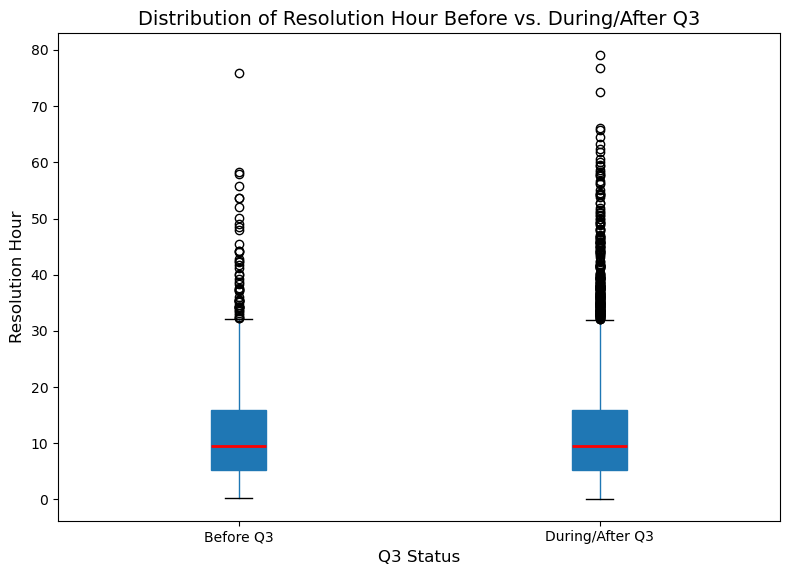

In [57]:
# 2. Generate descriptive statistics
stats = tickets.groupby('Q3_Status')['resolution_hours'].agg(['min','max','mean', 'median', 'std']).reset_index()
print("Descriptive Statistics for Resolution Hour:")
print(stats)

# 3. Create the box plot
fig, ax = plt.subplots(figsize=(8, 6))

tickets.boxplot(column='resolution_hours', by='Q3_Status', ax=ax, grid=False, patch_artist=True, medianprops={'color': 'red', 'linewidth': 2})

# Clean up the plot
plt.suptitle('') # Suppress the default title generated by df.boxplot
ax.set_title('Distribution of Resolution Hour Before vs. During/After Q3', fontsize=14)
ax.set_xlabel('Q3 Status', fontsize=12)
ax.set_ylabel('Resolution Hour', fontsize=12)
plt.xticks(rotation=0) # Ensure x-axis labels are horizontal
plt.tight_layout()
plt.show()

Proportions of Resolved by Q3 Status:
resolved                0         1
Q3_Status                          
Before Q3        0.085276  0.914724
During/After Q3  0.077516  0.922484


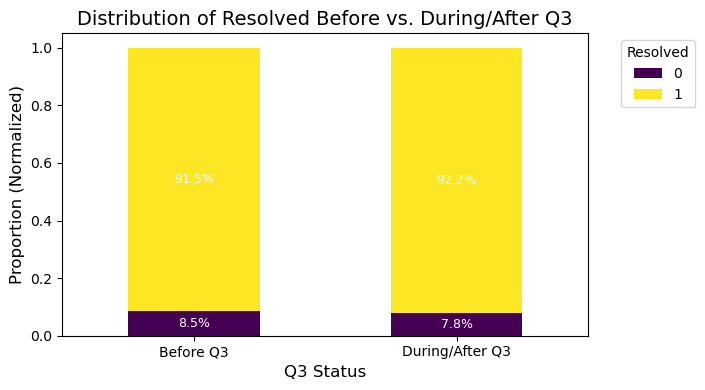

In [58]:
pivot_counts = pd.crosstab(tickets['Q3_Status'], tickets['resolved'])

# Normalize the counts within each Q3_Status group (index) to get proportions
pivot_proportions = pivot_counts.div(pivot_counts.sum(axis=1), axis=0)

# Display the proportions table (first 5 rows)
print("Proportions of Resolved by Q3 Status:")
print(pivot_proportions)

# 4. Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the normalized proportions as a stacked bar chart
pivot_proportions.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

# Add labels and title
ax.set_title('Distribution of Resolved Before vs. During/After Q3', fontsize=14)
ax.set_xlabel('Q3 Status', fontsize=12)
ax.set_ylabel('Proportion (Normalized)', fontsize=12)
ax.tick_params(axis='x', rotation=0)

# Add legend outside the plot
ax.legend(title='Resolved', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels inside the bars for clarity
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        width = bar.get_width()
        x = bar.get_x()
        y = bar.get_y()
        # Only add a label if the proportion is significant
        if height > 0.05:
             ax.text(x + width / 2, y + height / 2, f'{height:.1%}', ha='center', va='center', color='white', fontsize=9)

plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend
plt.show()

#### Fix EU Data

In [3]:
logs = pd.read_csv("data/logs.csv")
logs_cleaned = pd.read_csv("data/logs_cleaned.csv")

In [6]:
print(len(logs))

1098000


In [7]:
logs.head()

,Unnamed: 0,customer_id,date,logins,feature_events,session_minutes
0,0,C100000,2024-01-01,5.0,0.0,32.23
1,1,C100000,2024-01-02,1.0,1.0,18.08
2,2,C100000,2024-01-03,3.0,1.0,9.10
3,3,C100000,2024-01-04,3.0,1.0,37.60
4,4,C100000,2024-01-05,5.0,2.0,25.20


In [5]:
logs.isna().sum()

Unnamed: 0             0
customer_id            0
date                   0
logins             56010
feature_events     56010
session_minutes    56010
dtype: int64

#### Clean EU corrupt data in logs.csv

In [ ]:
logs_joined = pd.read_csv("data/sales_logs_joined.csv").drop(columns=["Unnamed: 0_x", "Unnamed: 0_y"], axis = 1)
logs_joined.head()

,customer_id,company_name,country,region,is_eu,industry,company_size_bucket,annual_contract_value,product_tier,sales_segment,...,contract_start_date,contract_end_date,renewed_flag,discount_pct,initial_onboarding_score,is_churned,date,logins,feature_events,session_minutes
0,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,2023-05-02,NaN,1,0.03,7.0,0,2024-01-01,5.0,0.0,32.23
1,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,2023-05-02,NaN,1,0.03,7.0,0,2024-01-02,1.0,1.0,18.08
2,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,2023-05-02,NaN,1,0.03,7.0,0,2024-01-03,3.0,1.0,9.10
3,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,2023-05-02,NaN,1,0.03,7.0,0,2024-01-04,3.0,1.0,37.60
4,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,2023-05-02,NaN,1,0.03,7.0,0,2024-01-05,5.0,2.0,25.20


In [12]:
logs_joined.isna().sum()

customer_id                      0
company_name                     0
country                          0
region                           0
is_eu                            0
industry                    315492
company_size_bucket              0
annual_contract_value            0
product_tier                     0
sales_segment                    0
acquisition_channel              0
contract_start_date              0
contract_end_date           522648
renewed_flag                     0
discount_pct                     0
initial_onboarding_score         0
is_churned                       0
date                             0
logins                       56010
feature_events               56010
session_minutes              56010
dtype: int64

In [17]:
logs_joined["date"] = pd.to_datetime(logs_joined["date"])

In [18]:
# 1. Configuration
activity_cols = ["logins", "feature_events", "session_minutes"]

# 2. Define the 'Corrupted' mask for EU September 2024
mask_corrupted = (
    (logs_joined["is_eu"] == 1) & 
    (logs_joined["date"] >= "2024-09-01") & 
    (logs_joined["date"] <= "2024-09-30")
)

print(f"Targeting {mask_corrupted.sum()} rows for repair in logs_joined.")

Targeting 56010 rows for repair in logs_joined.


In [21]:
# 1. Calculate the medians using only 'good' data
# We don't use transform here; we want a simple lookup table indexed by customer_id
lookup_table = logs_joined[~mask_corrupted].groupby("customer_id")[activity_cols].median()

# 2. Iterate through each column to fill the holes
for col in activity_cols:
    # 'map' looks at the customer_id in the corrupted row 
    # and finds the corresponding median in our lookup_table
    replacement_values = logs_joined.loc[mask_corrupted, "customer_id"].map(lookup_table[col])
    
    # Now we apply those mapped values to the nulls
    logs_joined.loc[mask_corrupted, col] = logs_joined.loc[mask_corrupted, col].fillna(replacement_values)

# Verify Step 1 worked
nulls_after_step1 = logs_joined.loc[mask_corrupted, activity_cols].isnull().sum()
print("Nulls remaining in corrupted rows after Step 1:")
print(nulls_after_step1)

Nulls remaining in corrupted rows after Step 1:
logins             0
feature_events     0
session_minutes    0
dtype: int64


In [50]:
logs_joined.isna().sum()

customer_id                      0
company_name                     0
country                          0
region                           0
is_eu                            0
industry                    315492
company_size_bucket              0
annual_contract_value            0
product_tier                     0
sales_segment                    0
acquisition_channel              0
contract_start_date              0
contract_end_date           522648
renewed_flag                     0
discount_pct                     0
initial_onboarding_score         0
is_churned                       0
date                             0
logins                           0
feature_events                   0
session_minutes                  0
Q3_Status                        0
dtype: int64

In [58]:
logs_joined.isna().sum()

customer_id                      0
company_name                     0
country                          0
region                           0
is_eu                            0
industry                    315492
company_size_bucket              0
annual_contract_value            0
product_tier                     0
sales_segment                    0
acquisition_channel              0
contract_start_date              0
contract_end_date           522648
renewed_flag                     0
discount_pct                     0
initial_onboarding_score         0
is_churned                       0
date                             0
logins                           0
feature_events                   0
session_minutes                  0
Q3_Status                        0
dtype: int64

In [59]:
logs_joined.to_csv("data/logs_joined.csv")

In [24]:
# Add Q3 status
month_number = logs_joined['date'].dt.month
is_q3_or_later = month_number >= 7

logs_joined['Q3_Status'] = np.where(
    is_q3_or_later,
    'During/After Q3',  # Value if True (Month is 7, 8, 9, 10, 11, or 12)
    'Before Q3'         # Value if False (Month is 1, 2, 3, 4, 5, or 6)
)

In [25]:
logs_joined.head()

,customer_id,company_name,country,region,is_eu,industry,company_size_bucket,annual_contract_value,product_tier,sales_segment,...,contract_end_date,renewed_flag,discount_pct,initial_onboarding_score,is_churned,date,logins,feature_events,session_minutes,Q3_Status
0,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,NaN,1,0.03,7.0,0,2024-01-01,5.0,0.0,32.23,Before Q3
1,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,NaN,1,0.03,7.0,0,2024-01-02,1.0,1.0,18.08,Before Q3
2,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,NaN,1,0.03,7.0,0,2024-01-03,3.0,1.0,9.10,Before Q3
3,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,NaN,1,0.03,7.0,0,2024-01-04,3.0,1.0,37.60,Before Q3
4,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,NaN,1,0.03,7.0,0,2024-01-05,5.0,2.0,25.20,Before Q3


In [26]:
to_joined = logs_joined[["customer_id", "Q3_Status", "logins", "feature_events", "session_minutes"]]

In [31]:
sales_login_aggregated = to_joined.groupby(["customer_id", "Q3_Status"]).mean().reset_index()
print(len(sales_login_aggregated))
sales_login_aggregated.head()

6000


,customer_id,Q3_Status,logins,feature_events,session_minutes
0,C100000,Before Q3,3.818681,1.318681,26.907198
1,C100000,During/After Q3,4.152174,1.548913,27.326420
2,C100001,Before Q3,0.972527,0.340659,13.701538
3,C100001,During/After Q3,0.978261,0.255435,12.655226
4,C100002,Before Q3,0.769231,0.329670,9.124231


In [51]:
sales_login_aggregated[sales_login_aggregated["customer_id"] == "C100010"]

,customer_id,Q3_Status,logins,feature_events,session_minutes
20,C100010,Before Q3,0.0,0.0,0.0
21,C100010,During/After Q3,0.0,0.0,0.0


In [30]:
sales_login_aggregated.to_csv("data/sales_login_aggregated.csv")

In [35]:
sale_cluster_tickets_regr = pd.read_csv("data/sale_cluster_tickets_regr.csv").drop(columns=["Unnamed: 0"], axis = 1)
print(len(sale_cluster_tickets_regr))
sale_cluster_tickets_regr.head()

6973


,customer_id,company_name,country,region,is_eu,industry,company_size_bucket,annual_contract_value,product_tier,sales_segment,...,priority,issue_category,ticket_text,avg_sentiment,avg_first_response_hours,avg_resolution_hours,avg_resolved,ticket_count,hierarchical_cluster,lost_revenue
0,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,Medium,product_performance,Dashboard loads very slowly during peak hours.,0.44,0.11,14.88,1.0,1.0,3,0.00
1,C100001,Company_1,UK,Europe,1,Wholesale,1-10,1799.72,Starter,SMB_Field,...,Low,product_performance,Dashboard loads very slowly during peak hours.,-0.50,8.12,9.37,1.0,1.0,4,0.00
2,C100002,Company_2,US,North America,0,Manufacturing,1-10,1770.83,Starter,SMB_Field,...,Medium,product_usability,The new dashboard is confusing for my staff.,-0.50,2.97,31.65,1.0,1.0,2,1770.83
3,C100003,Company_3,France,Europe,1,Missing,1-10,1790.30,Starter,SMB_Field,...,High,billing_admin,I need to change our billing email and can't f...,-0.11,0.10,12.49,1.0,1.0,3,0.00
4,C100004,Company_4,Netherlands,Europe,1,Professional Services,1-10,1552.00,Starter,SMB_Inside,...,Medium,product_performance,Inventory sync takes too long to complete.,0.20,5.19,35.67,1.0,1.0,4,1552.00


In [41]:
print(len(sale_cluster_tickets_regr))
sale_cluster_tickets_regr.isna().sum()

6973


customer_id                    0
company_name                   0
country                        0
region                         0
is_eu                          0
industry                       0
company_size_bucket            0
annual_contract_value          0
product_tier                   0
sales_segment                  0
acquisition_channel            0
contract_start_date            0
contract_end_date           3276
renewed_flag                   0
discount_pct                   0
initial_onboarding_score       0
is_churned                     0
Q3_Status                    579
channel                      579
priority                     579
issue_category               579
ticket_text                  579
avg_sentiment                579
avg_first_response_hours     579
avg_resolution_hours         579
avg_resolved                 579
ticket_count                 579
hierarchical_cluster           0
lost_revenue                   0
dtype: int64

In [40]:
sales_login_aggregated.isna().sum()

customer_id        0
Q3_Status          0
logins             0
feature_events     0
session_minutes    0
dtype: int64

In [53]:
print(sale_cluster_tickets_regr.columns)

Index(['customer_id', 'company_name', 'country', 'region', 'is_eu', 'industry',
       'company_size_bucket', 'annual_contract_value', 'product_tier',
       'sales_segment', 'acquisition_channel', 'contract_start_date',
       'contract_end_date', 'renewed_flag', 'discount_pct',
       'initial_onboarding_score', 'is_churned', 'Q3_Status', 'channel',
       'priority', 'issue_category', 'ticket_text', 'avg_sentiment',
       'avg_first_response_hours', 'avg_resolution_hours', 'avg_resolved',
       'ticket_count', 'hierarchical_cluster', 'lost_revenue'],
      dtype='object')


In [52]:
print(sale_cluster_tickets_regr.isna().sum())
print(sales_login_aggregated.isna().sum())

customer_id                    0
company_name                   0
country                        0
region                         0
is_eu                          0
industry                       0
company_size_bucket            0
annual_contract_value          0
product_tier                   0
sales_segment                  0
acquisition_channel            0
contract_start_date            0
contract_end_date           3276
renewed_flag                   0
discount_pct                   0
initial_onboarding_score       0
is_churned                     0
Q3_Status                    579
channel                      579
priority                     579
issue_category               579
ticket_text                  579
avg_sentiment                579
avg_first_response_hours     579
avg_resolution_hours         579
avg_resolved                 579
ticket_count                 579
hierarchical_cluster           0
lost_revenue                   0
dtype: int64
customer_id        0
Q3_Status

In [54]:
master = pd.merge(sales_login_aggregated, sale_cluster_tickets_regr, how = "left", on = ["customer_id", "Q3_Status"])
print(master.columns)
master.head()

Index(['customer_id', 'Q3_Status', 'logins', 'feature_events',
       'session_minutes', 'company_name', 'country', 'region', 'is_eu',
       'industry', 'company_size_bucket', 'annual_contract_value',
       'product_tier', 'sales_segment', 'acquisition_channel',
       'contract_start_date', 'contract_end_date', 'renewed_flag',
       'discount_pct', 'initial_onboarding_score', 'is_churned', 'channel',
       'priority', 'issue_category', 'ticket_text', 'avg_sentiment',
       'avg_first_response_hours', 'avg_resolution_hours', 'avg_resolved',
       'ticket_count', 'hierarchical_cluster', 'lost_revenue'],
      dtype='object')


,customer_id,Q3_Status,logins,feature_events,session_minutes,company_name,country,region,is_eu,industry,...,priority,issue_category,ticket_text,avg_sentiment,avg_first_response_hours,avg_resolution_hours,avg_resolved,ticket_count,hierarchical_cluster,lost_revenue
0,C100000,Before Q3,3.818681,1.318681,26.907198,Company_0,Canada,North America,0.0,Healthcare,...,Medium,product_performance,Dashboard loads very slowly during peak hours.,0.44,0.11,14.88,1.0,1.0,3.0,0.0
1,C100000,During/After Q3,4.152174,1.548913,27.326420,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C100001,Before Q3,0.972527,0.340659,13.701538,Company_1,UK,Europe,1.0,Wholesale,...,Low,product_performance,Dashboard loads very slowly during peak hours.,-0.50,8.12,9.37,1.0,1.0,4.0,0.0
3,C100001,During/After Q3,0.978261,0.255435,12.655226,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C100002,Before Q3,0.769231,0.329670,9.124231,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
master.to_csv("data/master.csv")

In [57]:
master.isna().sum()

customer_id                    0
Q3_Status                      0
logins                         0
feature_events                 0
session_minutes                0
company_name                2664
country                     2664
region                      2664
is_eu                       2664
industry                    2664
company_size_bucket         2664
annual_contract_value       2664
product_tier                2664
sales_segment               2664
acquisition_channel         2664
contract_start_date         2664
contract_end_date           5658
renewed_flag                2664
discount_pct                2664
initial_onboarding_score    2664
is_churned                  2664
channel                     2664
priority                    2664
issue_category              2664
ticket_text                 2664
avg_sentiment               2664
avg_first_response_hours    2664
avg_resolution_hours        2664
avg_resolved                2664
ticket_count                2664
hierarchic

In [56]:
master[master["logins"].isna()]

,customer_id,Q3_Status,logins,feature_events,session_minutes,company_name,country,region,is_eu,industry,...,priority,issue_category,ticket_text,avg_sentiment,avg_first_response_hours,avg_resolution_hours,avg_resolved,ticket_count,hierarchical_cluster,lost_revenue


In [60]:
sales

NameError: name 'sales' is not defined

In [ ]:
### LOGIN & MASTER

In [62]:
master = pd.read_csv("data/master_giant.csv")
print(master.columns)
master.head()

Index(['customer_id', 'company_name', 'country', 'region', 'is_eu', 'industry',
       'company_size_bucket', 'annual_contract_value', 'product_tier',
       'sales_segment', 'acquisition_channel', 'contract_start_date',
       'contract_end_date', 'renewed_flag', 'discount_pct',
       'initial_onboarding_score', 'is_churned', 'period', 'logins',
       'feature_events', 'session_minutes', 'channel_Chat', 'channel_Email',
       'channel_In-App', 'channel_Phone', 'priority_High', 'priority_Low',
       'priority_Medium', 'priority_Urgent', 'issue_category_billing_admin',
       'issue_category_product_performance',
       'issue_category_product_usability', 'issue_category_sales_expectation',
       'ticket_text_Bulk upload flow is not intuitive.',
       'ticket_text_Dashboard loads very slowly during peak hours.',
       'ticket_text_I need to change our billing email and can't find the option.',
       'ticket_text_Inventory sync takes too long to complete.',
       'ticket_text_It

,customer_id,company_name,country,region,is_eu,industry,company_size_bucket,annual_contract_value,product_tier,sales_segment,...,ticket_text_The reporting page keeps timing out.,ticket_text_VAT appears to be calculated incorrectly.,ticket_text_We expected multi-warehouse support out of the box.,ticket_text_We were charged for extra users we don't have.,"ticket_text_We were told onboarding would be fully managed, but it wasn't.",sentiment,resolution_hours,first_response_hours,resolved,total_ticket_count
0,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
1,C100000,Company_0,Canada,North America,0,Healthcare,51-200,12999.25,Growth,MidMarket,...,0.0,0.0,0.0,0.0,0.0,0.44,14.88,0.11,1.0,1.0
2,C100001,Company_1,UK,Europe,1,Wholesale,1-10,1799.72,Starter,SMB_Field,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
3,C100001,Company_1,UK,Europe,1,Wholesale,1-10,1799.72,Starter,SMB_Field,...,0.0,0.0,0.0,0.0,0.0,-0.50,9.37,8.12,1.0,1.0
4,C100002,Company_2,US,North America,0,Manufacturing,1-10,1770.83,Starter,SMB_Field,...,0.0,0.0,0.0,0.0,0.0,-0.50,31.65,2.97,1.0,1.0


In [69]:
no_login = master[master["logins"] == 0]

In [70]:
no_login

,customer_id,company_name,country,region,is_eu,industry,company_size_bucket,annual_contract_value,product_tier,sales_segment,...,ticket_text_The reporting page keeps timing out.,ticket_text_VAT appears to be calculated incorrectly.,ticket_text_We expected multi-warehouse support out of the box.,ticket_text_We were charged for extra users we don't have.,"ticket_text_We were told onboarding would be fully managed, but it wasn't.",sentiment,resolution_hours,first_response_hours,resolved,total_ticket_count
4,C100002,Company_2,US,North America,0,Manufacturing,1-10,1770.83,Starter,SMB_Field,...,0.0,0.0,0.0,0.0,0.0,-0.500,31.650,2.970000,1.0,1.0
8,C100004,Company_4,Netherlands,Europe,1,Professional Services,1-10,1552.00,Starter,SMB_Inside,...,0.0,0.0,0.0,0.0,0.0,0.200,35.670,5.190000,1.0,1.0
20,C100010,Company_10,US,North America,0,Ecommerce,1-10,1073.77,Starter,SMB_Inside,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
21,C100010,Company_10,US,North America,0,Ecommerce,1-10,1073.77,Starter,SMB_Inside,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
122,C100061,Company_61,US,North America,0,Hospitality,1-10,1073.10,Starter,SMB_Inside,...,0.0,0.0,0.0,0.0,0.0,-0.150,31.240,30.900000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5948,C102974,Company_2974,UK,Europe,1,Ecommerce,1-10,1723.86,Starter,SMB_Inside,...,0.0,0.0,0.0,1.0,1.0,-0.325,11.795,7.970000,1.0,2.0
5949,C102974,Company_2974,UK,Europe,1,Ecommerce,1-10,1723.86,Starter,SMB_Inside,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
5962,C102981,Company_2981,France,Europe,1,Wholesale,1-10,2011.06,Starter,SMB_Inside,...,1.0,0.0,0.0,0.0,0.0,-0.120,11.340,8.213333,1.0,3.0
5963,C102981,Company_2981,France,Europe,1,Wholesale,1-10,2011.06,Starter,SMB_Inside,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0


#### Weighted Contract Value lost by Issue Category

In [71]:
sales = pd.read_csv("data/sales_cleaned.csv")
tickets = pd.read_csv("data/dataset3.csv")

In [72]:
tickets.head()

,ticket_id,customer_id,created_at,channel,priority,issue_category,ticket_text,sentiment,first_response_hours,resolution_hours,resolved
0,200001,C100000,2024-05-12T23:17,Chat,Medium,product_performance,Dashboard loads very slowly during peak hours.,0.44,0.11,14.88,1
1,200002,C100001,2024-06-28T18:27,Email,Low,product_performance,Dashboard loads very slowly during peak hours.,-0.50,8.12,9.37,1
2,200003,C100002,2024-11-25T16:38,Email,Medium,product_usability,The new dashboard is confusing for my staff.,-0.50,2.97,31.65,1
3,200004,C100003,2024-11-02T14:37,Phone,High,billing_admin,I need to change our billing email and can't f...,-0.11,0.10,12.49,1
4,200005,C100004,2024-10-17T22:27,Phone,Medium,product_performance,Inventory sync takes too long to complete.,0.20,5.19,35.67,1


In [74]:
tickets.groupby(["customer_id", "issue_category"])["ticket_id"].count()

customer_id  issue_category     
C100000      product_performance    1
C100001      product_performance    1
C100002      product_usability      1
C100003      billing_admin          1
C100004      product_performance    1
                                   ..
C102997      sales_expectation      1
C102998      product_performance    1
C102999      billing_admin          3
             product_performance    1
             sales_expectation      2
Name: ticket_id, Length: 4654, dtype: int64

In [75]:
tickets.columns

Index(['ticket_id', 'customer_id', 'created_at', 'channel', 'priority',
       'issue_category', 'ticket_text', 'sentiment', 'first_response_hours',
       'resolution_hours', 'resolved'],
      dtype='object')

In [79]:
# create before and after Q3 time period
tickets["created_at"] = pd.to_datetime(tickets["created_at"])

month_number = tickets['created_at'].dt.month
is_q3_or_later = month_number >= 7

tickets['Q3_Status'] = np.where(
    is_q3_or_later,
    'During/After Q3',  # Value if True (Month is 7, 8, 9, 10, 11, or 12)
    'Before Q3'         # Value if False (Month is 1, 2, 3, 4, 5, or 6)
)

In [82]:
sales = pd.read_csv("data/sales_cleaned.csv")

In [81]:
# 1. Pivot the data to count tickets by issue_category for each customer
# fill_value=0 ensures customers with 0 tickets in a category get a 0 instead of NaN
category_counts = tickets.pivot_table(
    index=["customer_id", "Q3_Status"], 
    columns="issue_category", 
    values="ticket_id", 
    aggfunc="count", 
    fill_value=0
)

# 2. Calculate the total number of tickets for each customer
# We sum across the rows (axis=1)
total_tickets = category_counts.sum(axis=1)

# 3. Calculate the proportion for each category
# Divide each category count by the total tickets
# We use .div() with axis=0 to align by index (customer_id) correctly
category_proportions = category_counts.div(total_tickets, axis=0)

# 4. Rename columns for clarity (e.g., 'Billing' -> 'prop_Billing')
category_proportions.columns = [f"prop_{col}" for col in category_proportions.columns]

# Reset index so customer_id becomes a column again
category_proportions = category_proportions.reset_index()

# Inspect the result
category_proportions.head()

,customer_id,Q3_Status,prop_billing_admin,prop_product_performance,prop_product_usability,prop_sales_expectation
0,C100000,Before Q3,0.0,1.0,0.0,0.0
1,C100001,Before Q3,0.0,1.0,0.0,0.0
2,C100002,During/After Q3,0.0,0.0,1.0,0.0
3,C100003,During/After Q3,1.0,0.0,0.0,0.0
4,C100004,During/After Q3,0.0,1.0,0.0,0.0


In [83]:
# now outer join with Sales Cleaned
ticket_sales = category_proportions.merge(sales, on = "customer_id", how = "outer")
ticket_sales.head()

,customer_id,Q3_Status,prop_billing_admin,prop_product_performance,prop_product_usability,prop_sales_expectation,Unnamed: 0,company_name,country,region,...,annual_contract_value,product_tier,sales_segment,acquisition_channel,contract_start_date,contract_end_date,renewed_flag,discount_pct,initial_onboarding_score,is_churned
0,C100000,Before Q3,0.0,1.0,0.0,0.0,0,Company_0,Canada,North America,...,12999.25,Growth,MidMarket,Partner,2023-05-02,NaN,1,0.03,7.0,0
1,C100001,Before Q3,0.0,1.0,0.0,0.0,1,Company_1,UK,Europe,...,1799.72,Starter,SMB_Field,Inbound,2023-02-18,NaN,1,0.15,4.9,0
2,C100002,During/After Q3,0.0,0.0,1.0,0.0,2,Company_2,US,North America,...,1770.83,Starter,SMB_Field,Inbound,2023-11-12,2024-05-13,0,0.37,4.8,1
3,C100003,During/After Q3,1.0,0.0,0.0,0.0,3,Company_3,France,Europe,...,1790.30,Starter,SMB_Field,Outbound,2023-08-06,NaN,1,0.10,8.0,0
4,C100004,During/After Q3,0.0,1.0,0.0,0.0,4,Company_4,Netherlands,Europe,...,1552.00,Starter,SMB_Inside,Inbound,2023-09-09,2024-03-10,0,0.11,3.8,1


In [84]:
is_churned = ticket_sales[ticket_sales["is_churned"] == 1]

In [86]:
is_churned = is_churned.fillna(0)

In [87]:
is_churned.columns

Index(['customer_id', 'Q3_Status', 'prop_billing_admin',
       'prop_product_performance', 'prop_product_usability',
       'prop_sales_expectation', 'Unnamed: 0', 'company_name', 'country',
       'region', 'is_eu', 'industry', 'company_size_bucket',
       'annual_contract_value', 'product_tier', 'sales_segment',
       'acquisition_channel', 'contract_start_date', 'contract_end_date',
       'renewed_flag', 'discount_pct', 'initial_onboarding_score',
       'is_churned'],
      dtype='object')

In [88]:
is_churned["Product_Lost_Contract"] = (is_churned["prop_product_performance"] + is_churned["prop_product_usability"]) * is_churned["annual_contract_value"]
is_churned["Sales_Lost_Contract"] = is_churned["prop_sales_expectation"] * is_churned["annual_contract_value"]
is_churned["Billing_Lost_Contract"] = is_churned["prop_billing_admin"] * is_churned["annual_contract_value"]

In [90]:
is_churned.groupby("Q3_Status")[["Product_Lost_Contract","Sales_Lost_Contract",  "Billing_Lost_Contract"]].sum()

,Product_Lost_Contract,Sales_Lost_Contract,Billing_Lost_Contract
Q3_Status,,,
0,0.000000e+00,0.000000,0.000000e+00
Before Q3,5.192099e+05,121829.072000,5.720661e+05
During/After Q3,1.999403e+06,943628.749389,1.082750e+06


In [89]:
print(is_churned["Product_Lost_Contract"].sum())
print(is_churned["Sales_Lost_Contract"].sum())
print(is_churned["Billing_Lost_Contract"].sum())

2518612.675138889
1065457.821388889
1654815.963472222
